In [1]:
from plots import *

Some options

In [2]:
agg = 'leaderboard' # 'leaderboard', 'scenarios'
results = 'acc'# 'acc', 'rank'

Computing numbers to show in plots

In [3]:
if results == 'acc': ylim = (0,.1)
elif results == 'rank': 
    if agg_metric == 'std': ylim = (0,.1)
    else: ylim = (.5,1)
else: raise NotImplementedError
    
table_avg = {}
table_std = {}
model_perf = {}
for bench in benchs:
    table_avg[bench] = {}
    table_std[bench] = {}
    model_perf[bench] = {}
        
    for split in splits[bench]:
        table_avg[bench][split] = {}
        table_std[bench][split] = {}
        model_perf[bench][split] = {}
        

        with open(f'results/accs_{bench}_split-{split}_iterations-5.pickle', 'rb') as handle:
            data = pickle.load(handle)

        models = list(data.keys())
        number_items = list(data[models[0]].keys())
        scenarios = list(data[models[0]][number_items[0]][methods[0]].keys())
        data = np.array([[[[data[model][number_item][method][scenario] for scenario in scenarios]  for model in data.keys()] for number_item in number_items] for method in methods])
        scores = load_scores(bench, split)
        
        if agg == 'leaderboard':
            if bench=='helm': 
                ###
                if results == 'acc':
                    ###
                    model_perf[bench][split]['truth'] = winrate(scores, axis=1).mean(axis=0)
                    for i,method in enumerate(methods):
                        model_perf[bench][split][method] = {}
                        model_perf[bench][split][method] = {}
                        for j,number_item in enumerate(number_items):
                            model_perf[bench][split][method][number_item] = winrate(data, axis=2).mean(axis=3)[i,j,:,:]
                    ###
                    data = np.abs(winrate(data, axis=2).mean(axis=3)-winrate(scores, axis=1).mean(axis=0)[None,None,:,None])
                elif results == 'rank': 
                    rank_corrs = np.zeros(data.mean(axis=2).mean(axis=2).shape)
                    #print(bench,rank_corrs.shape)
                    for i in range(rank_corrs.shape[0]):
                        for j in range(rank_corrs.shape[1]):
                            for l in range(rank_corrs.shape[2]):
                                #print(winrate(data, axis=2).mean(axis=3).shape)
                                rank_corrs[i,j,l] = stats.spearmanr(winrate(data, axis=2).mean(axis=3)[i,j,:,l], winrate(scores.T, axis=0).mean(axis=1)).statistic
                    data=rank_corrs

                else: 
                    raise NotImplementedError
            else: 
                ###
                if results == 'acc':
                    ###
                    model_perf[bench][split]['truth'] = scores.mean(axis=0)
                    for i,method in enumerate(methods):
                        model_perf[bench][split][method] = {}
                        model_perf[bench][split][method] = {}
                        for j,number_item in enumerate(number_items):
                            model_perf[bench][split][method][number_item] = data.mean(axis=3)[i,j,:,:]
                    ###
                    data = np.abs(data.mean(axis=3)-scores.mean(axis=0)[None,None,:,None])
                elif results == 'rank': 
                    rank_corrs = np.zeros(data.mean(axis=2).mean(axis=2).shape)
                    #print(bench,rank_corrs.shape)
                    for i in range(rank_corrs.shape[0]):
                        for j in range(rank_corrs.shape[1]):
                            for l in range(rank_corrs.shape[2]):
                                #print(data.mean(axis=3).shape)
                                rank_corrs[i,j,l] = stats.spearmanr(data.mean(axis=3)[i,j,:,l], scores.T.mean(axis=1)).statistic
                    data=rank_corrs
                else: 
                    raise NotImplementedError
        elif agg == 'scenarios':
            if results == 'acc': 
                data = np.abs(data-scores.T[None,None,:,:,None]).mean(axis=3)
            elif results == 'rank': 
                rank_corrs = np.zeros(data.mean(axis=2).shape)
                for i in range(rank_corrs.shape[0]):
                    for j in range(rank_corrs.shape[1]):
                        for k in range(rank_corrs.shape[2]):
                            for l in range(rank_corrs.shape[3]):
                                rank_corrs[i,j,k,l] = stats.spearmanr(data[i,j,:,k,l], scores.T[:,k]).statistic
                data=rank_corrs
            else: 
                raise NotImplementedError
        else:
            raise NotImplementedError
            
        if agg_metric=='avg':
            data = data.mean(-1) #iterations
        elif agg_metric=='std':
            data = data.std(-1)
        else:
            raise NotImplementedError
            
        
        for i,method in enumerate(methods):
            table_avg[bench][split][method] = {}
            table_std[bench][split][method] = {}

            for j,number_item in enumerate(number_items):
                if agg == 'leaderboard' and results == 'rank':
                    #print(data.shape)
                    table_avg[bench][split][method][number_item] = data[i,j]
                    table_std[bench][split][method][number_item] = 0
                else: 
                    #print(data.shape)
                    table_avg[bench][split][method][number_item] = np.mean(data, axis=-1)[i,j]
                    table_std[bench][split][method][number_item] = data.std(-1)[i,j]

Plots showing individual performances

In [4]:
if results == 'acc':
    if agg == 'leaderboard':
        split = 'noniid'
        iteration = 1
        number_item = 100

        alphas = {'random_naive':.4,'anchor_naive':.4,'anchor-irt_naive':.4,'anchor-irt_gpirt':.8}
        markersize = {'random_naive':7,'anchor_naive':5,'anchor-irt_naive':5,'anchor-irt_gpirt':5}
        names = {'random_naive':'random','anchor-irt_naive':'IRT ','anchor_naive':'correctness','anchor-irt_gpirt':'IRT++'}
        plt.figure(figsize=(1.2*3.5,1.2*3))

        for i,bench in enumerate(['mmlu']): #benchs[:4]
            axis = {'lb':'avg. score', 'mmlu':'accuracy', 'helm':'mean win rate', 'alpaca':'win rate'}
            for method in ['anchor-irt_gpirt']: #

                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                label = "{:} (error={:.3f}, $r_S$={:.2f})".format(names[method], np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                plt.plot(x, y, 'o', label = label, markersize=markersize[method],alpha=alphas[method], color =color_mappings[method])

            plt.legend(fontsize=10, framealpha=.9)
            #plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.2)
            plt.xlabel('true '+axis[bench], size=12)
            plt.ylabel('predicted '+axis[bench], size=12)
            plt.xlim(0,1)
            plt.ylim(0,1)
            tick_label_size = 11  # Example size, adjust as needed
            plt.tick_params(axis='x', labelsize=tick_label_size)
            plt.tick_params(axis='y', labelsize=tick_label_size)

        plt.tight_layout()
        plt.savefig('plots/mmlu_leaderboard_performance_individual.png', bbox_inches='tight', dpi=400, transparent=True)
        plt.show()

In [5]:
if results == 'acc':
    if agg == 'leaderboard':
        split = 'noniid'
        iteration = 1
        number_item = 100

        alphas = {'random_naive':.4,'anchor_naive':.5,'anchor-irt_naive':.5,'anchor-irt_gpirt':.6}
        markersize = {'random_naive':5,'anchor_naive':4,'anchor-irt_naive':4,'anchor-irt_gpirt':3}
        names = {'random_naive':'random','anchor-irt_naive':'IRT ','anchor_naive':'correct.','anchor-irt_gpirt':'IRT++'}
        plt.figure(figsize=(13,3))

        for i,bench in enumerate(benchs[:4]): #benchs[:4]
            plt.subplot(1, 4, i+1)
            axis = {'lb':'performance', 'mmlu':'accuracy', 'helm_lite':'mean win rate', 'alpaca':'win rate'}
            for method in ['random_naive','anchor-irt_naive','anchor-irt_gpirt']: #

                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                label = "{:} (error={:.3f}, $r_S$={:.2f})".format(names[method], np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                plt.plot(x, y, 'o', label = label, markersize=markersize[method],alpha=alphas[method], color =color_mappings[method])

            plt.legend(fontsize=8, framealpha=.9)
            plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.2)
            plt.xlabel('true '+axis[bench], size=11)
            plt.ylabel('predicted '+axis[bench], size=11)
            plt.xlim(0,1)
            plt.ylim(0,1)
            tick_label_size = 10  # Example size, adjust as needed
            plt.tick_params(axis='x', labelsize=tick_label_size)
            plt.tick_params(axis='y', labelsize=tick_label_size)

        plt.tight_layout()
        plt.savefig('plots/leaderboard_performance_individual.png', bbox_inches='tight', dpi=400, transparent=True)
        plt.show()

Plots for aggregated performances

In [6]:
style = {"alpha":1, "markersize":3, "markeredgewidth":1, "elinewidth":1, "capsize":3, "linestyle":''}

def plot_perf_lines(table_avg, table_std, title, xlabel, ylabel, ylim,
                    legend=False, error_bar=False, show_title=True, show_xlabel=True, show_ylabel=True, ncols=6, posic=(-1.5, -.35)):
    
    markers = ['o', 'v', '*', 'x', 's','p']
    jitters = [-6.3,-3.7,-1.3,1.3,3.7,6.3]
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'][:9]
    j=0
    for method, values in table_avg.items():
        x = np.array(list(values.keys()))
        y = np.array(list(values.values()))
        s = np.array(list(table_std[method].values()))
        
        if error_bar: 
            plt.errorbar(x+jitters[j], y, color =color_mappings[method], yerr=s, label=rename_mappings[method], marker=markers[j], **style)
        else: 
            plt.plot(x, y, label=method)

        j+=1
    if show_xlabel: plt.xlabel(xlabel, size=11)
    if show_ylabel: plt.ylabel(ylabel, size=11)
    plt.ylim(ylim[0], ylim[1])
    if show_title:
        plt.title(title)
    else:
        pass
    
    tick_label_size = 10  # Example size, adjust as needed
    plt.tick_params(axis='x', labelsize=tick_label_size)
    plt.tick_params(axis='y', labelsize=tick_label_size)
    
    if legend: plt.legend(loc='upper center', ncols=ncols, bbox_to_anchor=posic)
    plt.grid(alpha=.2)
    #plt.grid(which='major', color='black', linestyle='-')
    #plt.grid(which='minor', color='gray', linestyle=':')
    #plt.show()
    

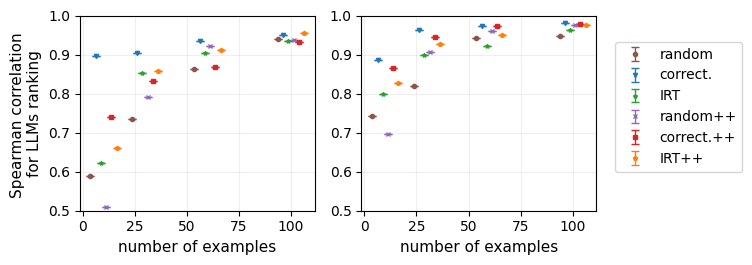

In [7]:
plt.figure(figsize=(8,2.75))
bench='mmlu_fields'
# Iterate over your benchmarks
for i, split in enumerate(splits[bench]):  # Replace `benchmarks` with your list of benchmarks
    # Plot on the ith subplot
    plt.subplot(1, 2, i+1)
    if results == 'rank': ylabel='Spearman correlation \nfor LLMs ranking'
    else: ylabel='accuracy estimation error'
        
    plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                    title='',
                    xlabel='number of examples',
                    ylabel=ylabel, ylim=ylim, legend=i==1, error_bar=True, show_ylabel=split=='iid', ncols=1, posic=(1.35, .9))
    plt.tight_layout()
plt.savefig(f'plots/mmlu_performance_specialized_models_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()

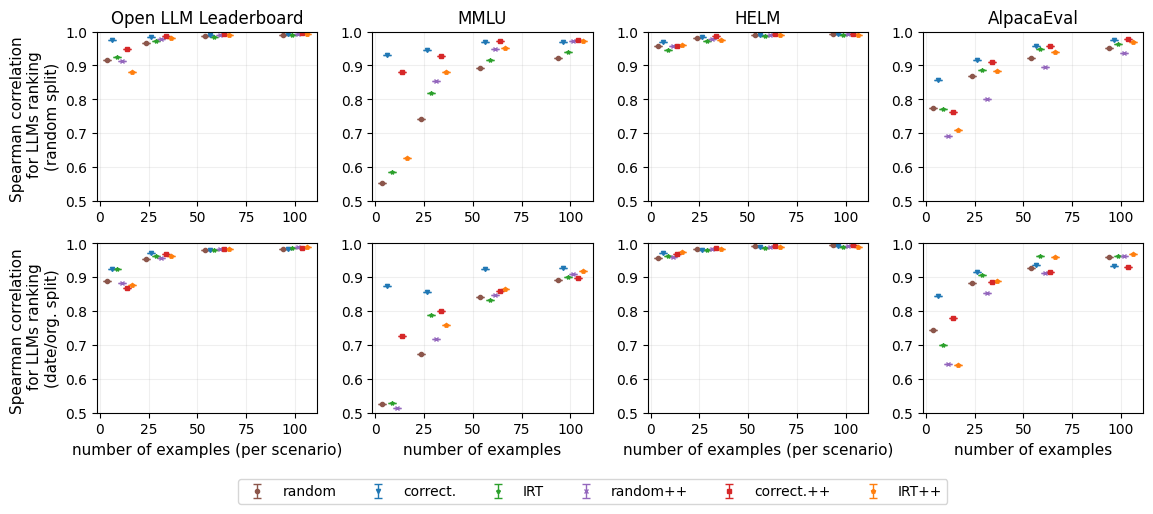

In [8]:
if agg == 'leaderboard':
    plt.figure(figsize=(.9*15,.9*5.5))
    plt.subplots_adjust(wspace=.25, hspace=.25)
    
    for j, split in enumerate(splits[bench]):
        ylabel_dic = {'iid':'(random split)', 'noniid':'(date/org. split)'}
        if results == 'rank': ylabel=f'Spearman correlation \n for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'performance est. error\n{ylabel_dic[split]}'
  
        # Iterate over your benchmarks
        for i, bench in enumerate(benchs[:4]):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of examples'
            else: xlabel='number of examples (per scenario)'    
            # Plot on the ith subplot
            plt.subplot(2, 4, 4*j + i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=((i+1==4) and split=='noniid'),
                            error_bar=True,show_title=split=='iid', show_xlabel=split=='noniid', show_ylabel=bench=='lb')#ylims[bench]

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/leaderboard_performance_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

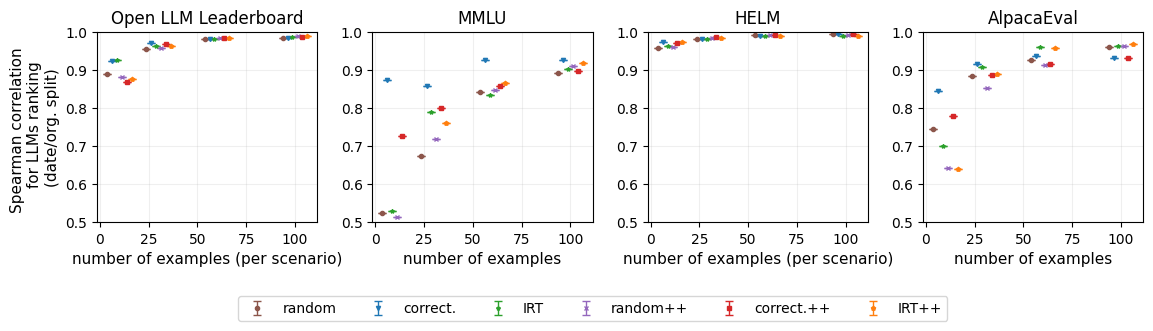

In [9]:
# Same plot as above
if agg == 'leaderboard':
    plt.figure(figsize=(.9*15,.9*5.5/2))
    plt.subplots_adjust(wspace=.25, hspace=.25)
    
    for j, split in enumerate(['noniid']):
        ylabel_dic = {'iid':'(random split)', 'noniid':'(date/org. split)'}
        if results == 'rank': ylabel=f'Spearman correlation \n for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'performance est. error\n{ylabel_dic[split]}'
  
        # Iterate over your benchmarks
        for i, bench in enumerate(benchs[:4]):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of examples'
            else: xlabel='number of examples (per scenario)'    
            # Plot on the ith subplot
            plt.subplot(1, 4, 4*j + i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=((i+1==4) and split=='noniid'),
                            error_bar=True,show_title=split=='noniid', show_xlabel=split=='noniid', show_ylabel=bench=='lb')#ylims[bench]

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/leaderboard_performance_{results}_noniid.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

In [10]:
if agg == 'scenarios':
    plt.figure(figsize=(.5*.9*15,.9*5.5))
    plt.subplots_adjust(wspace=.25, hspace=.25)
    
    for j, split in enumerate(splits[bench]):
        # Create a figure and a set of subplots
        

        ylabel_dic = {'iid':'(random split)', 'noniid':'(date/org. split)'}
        
        if results == 'rank': ylabel=f'avg. scenarios Spearman\n  corr. for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'avg. scenarios\n performance est. error\n{ylabel_dic[split]}'

        # Iterate over your benchmarks
        for i, bench in enumerate(['lb','helm_lite']):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of examples'
            else: xlabel='number of examples (per scenario)'    
            # Plot on the ith subplot
            plt.subplot(2, 2, 2*j +i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=(j==1 and i==1),error_bar=True,
                            show_title=split=='iid', show_xlabel=split=='noniid', show_ylabel=bench=='lb', posic=(-.2, -.35))

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/avg_scenarios_performance_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

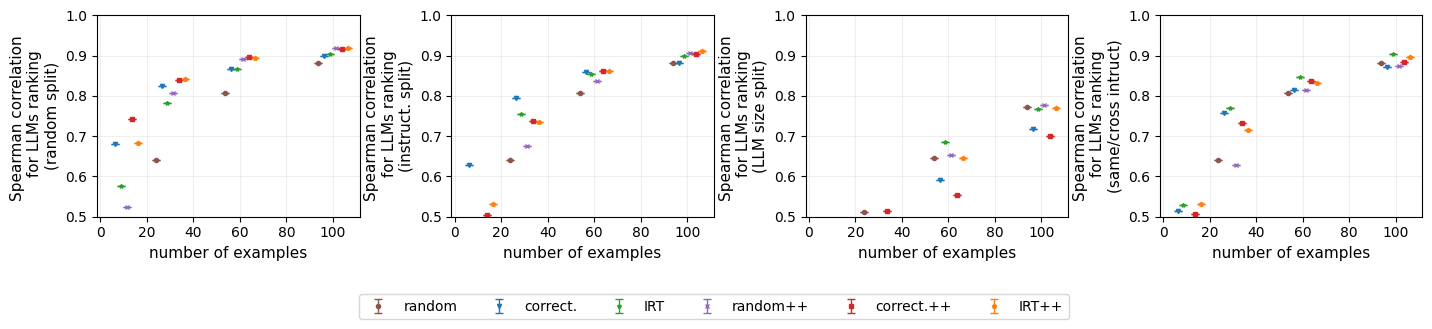

In [11]:
if agg == 'leaderboard':
    plt.figure(figsize=(.95*18,.95*5.5/2))
    plt.subplots_adjust(wspace=.35, hspace=.25)
    
    for j, split in enumerate(splits['icl_templates']):
        ylabel_dic = {'iid':'(random split)', 'noniid':'(instruct. split)', 'noniid2':'(LLM size split)', 'noniid3':'(same/cross intruct)'}
        if results == 'rank': ylabel=f'Spearman correlation \n for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'performance est. error\n{ylabel_dic[split]}'
  
        # Iterate over your benchmarks
        for i, bench in enumerate(['icl_templates']):  # Replace `benchmarks` with your list of benchmarks
            xlabel='number of examples'    
            # Plot on the ith subplot
            plt.subplot(1, 4, j + i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=(split=='noniid'),
                            error_bar=True,show_title=False, show_xlabel=True, show_ylabel=True,
                            posic=(1, -.35))#ylims[bench]

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/icl_templates_{results}.png', bbox_inches='tight', dpi=400, transparent=False)
    plt.show()